The first part of the code imports the necessary libraries and sets the seed for the random number generator. Specifically, it imports numpy and matplotlib.pyplot libraries and sets the seed to 32.

In [304]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(32)

define a class ActFunction that serves as a base class for activation functions. It has two methods, run and gradient, which are not implemented in this class.

Then, define six classes that inherit from ActFunction class, each implementing a different activation function. These activation functions are Tanh, Sigmoid, Softmax, ReLU, and Linear. Each of these classes implements the run and gradient methods with the corresponding activation function and its derivative.

In [312]:
class ActFunction:
    def run(self, z):
        pass
    def gradient(self, z):
        pass


class Tanh(ActFunction):
    def run(self, z):
        return np.tanh(z)

    def gradient(self, z):
        return 1 - np.tanh(z)**2


class Sigmoid(ActFunction):
    def run(self, z):
        return 1/(1+np.exp(-z))

    def gradient(self, z):
        return self.run(z) * (1 - self.run(z))


class Softmax(ActFunction):
    def run(self, z):
        return np.exp(z)/np.sum(np.exp(z))

    def gradient(self, z):
        return self.run(z) * (1 - self.run(z))


class ReLU(ActFunction):
    def run(self, z):
        zeros = np.zeros(shape=z.shape)
        return np.maximum(zeros, z)

    def gradient(self, z):
        result = np.array(z > 0, dtype=np.float32)
        return result


class Linear(ActFunction):
    def run(self, z):
        return z

    def gradient(self, z):
        return 1

Here define three classes: Loss, MSE, and CrossEntropy. The Loss class is an abstract base class that defines two methods: calculate and gradient. The MSE and CrossEntropy classes inherit from Loss and implement their own versions of calculate and gradient.

The MSE class implements the mean squared error loss function, which is commonly used in regression problems. The calculate method computes the mean squared error between the true labels y and the predicted labels y_hat. The gradient method computes the gradient of the mean squared error with respect to y_hat.

The CrossEntropy class implements the binary cross-entropy loss function, which is commonly used in binary classification problems. The calculate method computes the binary cross-entropy loss between the true labels y and the predicted probabilities y_hat. The gradient method computes the gradient of the binary cross-entropy with respect to y_hat.

In [313]:
class Loss:
    def calculate(self, y, y_hat):
        pass

    def gradient(self, y, y_hat):
        pass


class MSE(Loss):
    def calculate(self, y, y_hat):
        return np.mean((y-y_hat)**2)/2

    def gradient(self, y, y_hat):
        return (y_hat-y)


class CrossEntropy(Loss):
    def calculate(self, y, y_hat):
        epsilon = 1e-7  # Small constant to avoid log(0)

        # Clip predicted probabilities to avoid log(0) or log(1)
        y_pred = np.clip(y_hat, epsilon, 1 - epsilon)

        # Compute individual terms of BCE loss
        term_0 = (1 - y) * np.log(1 - y_pred)
        term_1 = y * np.log(y_pred)

        # Calculate overall loss
        loss = -np.mean(term_0 + term_1)

        return loss

    def gradient(self, y, y_hat):
        first_term = (1 - y) / (1 - y_hat)
        second_term = -y / y_hat
        return (first_term + second_term)

Class FCLayer represents a fully connected layer in a neural network. The class has several attributes such as input_shape, output_shape, weights, biases, inputs, linear_outputs, learning_rate, and activation. It also has two methods, forward and backward.

The forward method takes an input x, computes the dot product of the input with the weights, adds the biases, applies the activation function, and returns the output.

The backward method takes the gradient of the next layer as input, computes the gradient of the current layer, updates the weights and biases, and returns the gradient of the input to the current layer.

-------------------------------------

Class MLPModel has four methods: init, add_layer, train, and inference.

The init method initializes the model’s layers and loss function. The layers argument is a list of Layer objects that define the model’s architecture. The loss argument is a function that computes the loss between the model’s predictions and the true labels.

The add_layer method adds a new layer to the model’s architecture.

The train method trains the model on a given dataset. The x argument is a numpy array of input data, and y is a numpy array of true labels. The n_epochs argument specifies the number of epochs to train for. The show argument specifies whether to print the loss for each epoch. The method returns a list of the mean loss for each epoch.

The inference method performs inference on a given dataset. The x argument is a numpy array of input data. The method returns a numpy array of the model’s predictions.

In [338]:
# Define a class FCLayer
class FCLayer:
    # Define the constructor
    def __init__(self, inp_shape, out_shape, activation:ActFunction, learning_rate=0.01) -> None:
        # Initialize the input shape, output shape, weights, biases, inputs, linear outputs, learning rate, and activation function
        self.input_shape = inp_shape
        self.output_shape = out_shape
        self.weights = np.random.uniform(-1, 1, size=(self.output_shape, self.input_shape))
        self.biases = np.random.uniform(-1, 1, size=(self.output_shape, 1))
        self.inputs = None
        self.linear_outputs = None
        self.learning_rate = learning_rate
        self.activation = activation()

    # Define a method to perform the forward pass
    def forward(self, x):
        # Save the inputs
        self.inputs = x
        # Compute the linear outputs
        z = np.dot(self.weights, x)
        z = z + self.biases
        self.linear_outputs = z
        # Apply the activation function and return the output
        output = self.activation.run(z)
        return output

    # Define a method to perform the backward pass
    def backward(self, next_layer_gradient):
        # Compute the gradient of the activation function
        g = self.activation.gradient(self.linear_outputs)
        # Compute the gradients of the weights and biases
        dL_dW = np.dot((next_layer_gradient * g), self.inputs.reshape((1, self.input_shape)))
        dL_db = next_layer_gradient * g
        # Update the weights and biases
        self.weights = self.weights - self.learning_rate * dL_dW
        self.biases = self.biases - self.learning_rate * dL_db
        # Compute the gradient of the input to this layer and return it
        dL_da = np.dot(self.weights.T, next_layer_gradient * g)
        return dL_da


# Define a class MLPModel
class MLPModel:
    # Define the constructor
    def __init__(self, layers=[], loss=MSE) -> None:
        # Initialize the layers and loss
        self.layers = layers
        self.loss = loss()

    # Define a method to add a layer
    def add_layer(self, layer):
        self.layers.append(layer)

    # Define a method to train the model
    def train(self, x, y, n_epochs, show=True):
        # Initialize the losses list
        losses = []
        # Loop over the epochs
        for epoch in range(n_epochs):
            # Initialize the loss list for this epoch
            lo = []
            # Loop over the training data
            for i, xi in enumerate(x):
                # Forward pass through the layers
                for l in self.layers:
                    xi = l.forward(xi)
                # Calculate the gradient and loss
                grad = self.loss.gradient(y[i], xi)
                loss = self.loss.calculate(y[i], xi)
                # Append the loss to the loss list
                lo.append(loss)
                # Backward pass through the layers
                for l in self.layers[::-1]:
                    grad = l.backward(grad)
            # Append the mean loss for this epoch to the losses list
            losses.append(np.array(lo).mean())
            # Print the mean loss for this epoch if show is True
            if show:
                print(f'{epoch}  loss: {np.array(lo).mean()}')
        # Return the losses list
        return losses

    # Define a method to perform inference
    def inference(self, x):
        # Initialize the output list
        output = []
        # Loop over the input data
        for xi in x:
            # Forward pass through the layers
            for l in self.layers:
                xi = l.forward(xi)
            # Append the output to the output list
            output.append(xi)
        # Return the output as a numpy array
        return np.array(output)


In [339]:
# Create an instance of the MLPModel class
model = MLPModel()

# Create four instances of the FCLayer class with different input and output shapes and the Tanh activation function
l1 = FCLayer(2, 8, Tanh)
l2 = FCLayer(8, 4, Tanh)
l3 = FCLayer(4, 2, Tanh)
l4 = FCLayer(2, 1, Tanh)

# Add the four layers to the MLPModel instance
model.add_layer(l1)
model.add_layer(l2)
model.add_layer(l3)
model.add_layer(l4)


In [340]:
x = np.array([[[-1], [-1]], [[-1], [1]], [[1], [-1]], [[1], [1]]])
y = np.array([[[1]], [[-1]], [[-1]], [[1]]])

losses = model.train(x, y, 1000, show=False)

## Illustrating the loss

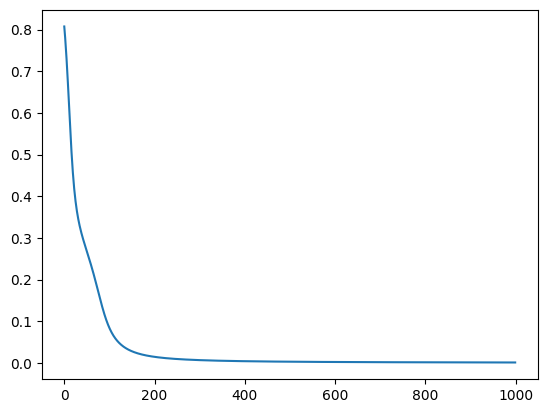

In [342]:

plt.plot(range(len(losses)), losses)

## Measuring the accuracy

In [344]:
x_test = np.array([[[1], [-1]], [[-1], [1]], [[1], [1]], [[-1], [-1]]])
y_test = np.array([[[-1]], [[-1]], [[1]], [[1]]])

inference = model.inference(x_test)
inference = np.sign(inference)
print('accuracy: ')
(inference == y_test).sum() / len(y_test)

accuracy: 


1.0